## DU Data Scientist project 2024
### Date: 2024-10-31
#### Author : Jonathan Kitt

## <u>Part 1 - Using the reciprocal of the cumulative distribution</u>

In [237]:
# Load the python libraries we will be using for the analysis

import numpy as np               # for calculations
import scipy as sp               # for scientific calculation
import pandas as pd              # for dataframe manipulation
import matplotlib.pyplot as plt  # for plots
from matplotlib.patches import Rectangle  # to create custom legends

In [3]:
# Set random seed for reproducibility
np.random.seed(123)

In [5]:
# Define a percent point function

def ppf(x, lambda_val = 1):

    '''
    Calculate percent point (or quantile) function, or ppf
    for a vector of random probabilities

    ---------------
    Parameters
    ---------------
    
    x: vector of random probabilities
    
    lambda_val: parameter value (defaults to 1)

    ---------------
    Returns
    ---------------

    A vector of values resulting from applying a percent point function to a vector
    of probabilities for a given lambda parameter (defaults to 1)
    '''
    
    res = (np.log(x / (1 - x))) / lambda_val
    
    return res

### _Question 1_

In [7]:
# Generate a sample of 10**6 random probabilities p_k, uniformily distributed in [0, 1]

p_k = np.random.uniform(low = 0, high = 1, size = 10**6)

# Check the size of the sample we generated

print(len(p_k))

# Print the first five elements of the sample

print(p_k[0:5])

1000000
[0.69646919 0.28613933 0.22685145 0.55131477 0.71946897]


In [9]:
# For each random value p_k, estimate x_k for a lambda parameter equal to 1

x_k = ppf(x = p_k)

# Print the first five elements of x_k

print(x_k[0:5])

[ 0.83054041 -0.91420892 -1.22617579  0.20598432  0.94182905]


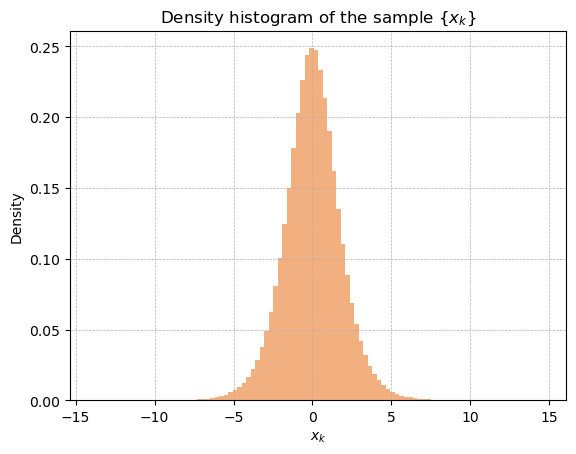

In [11]:
# Draw the density histogram of the sample x_k

plt.hist(x = x_k, bins = 100, color = '#e66100', density = True, alpha = 0.5);
plt.title('Density histogram of the sample {$x_k$}');
plt.xlabel('$x_k$');
plt.ylabel('Density');
plt.grid(linestyle = '--', linewidth = 0.5);

### _Question 2_

In [13]:
# Define a probability density function

def pdf(x, lambda_val = 1):
    '''
    Calculate probability density function, or pdf
    for a vector of random probabilities

    ---------------
    Parameters
    ---------------
    
    x: vector of random probabilities
    
    lambda_val: parameter value (defaults to 1)

    ---------------
    Returns
    ---------------

    A vector of values resulting from applying a probability density function to a vector
    of probabilities for a given lambda parameter (defaults to 1)
    '''
    res = (lambda_val / 4) * (1 / np.cosh(lambda_val * x / 2))**2
    return res

In [15]:
# Derive the explicit expression of the probability density function (pdf) on the x_k values for lambda = 1

f_x = pdf(x = x_k)

# Check the size of f_x

print(len(f_x))

# Print the first five elements of f_x

print(f_x[0:5])

1000000
[0.21139986 0.20426362 0.17538987 0.24736679 0.20183337]


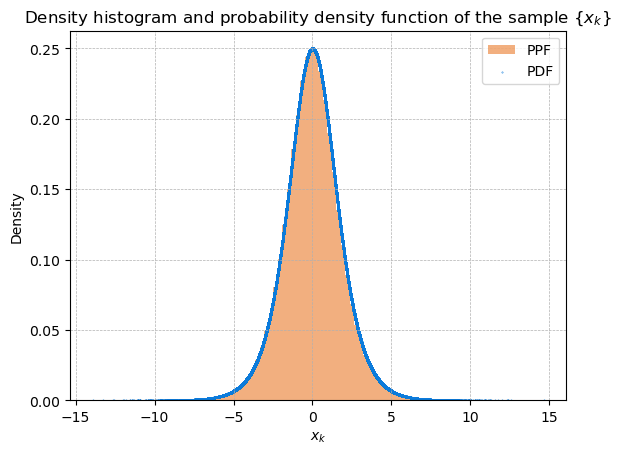

In [17]:
# Superimpose the f_x(x_k, 1) density curve on the sample histogram 

plt.hist(x = x_k, bins = 100, color = '#e66100', alpha = 0.5, density = True, label = 'PPF');
plt.scatter(x = x_k, y = f_x, label = 'PDF', color = '#0c7bdc', s = 0.1);
plt.title('Density histogram and probability density function of the sample {$x_k$}');
plt.xlabel('$x_k$');
plt.ylabel('Density');
plt.grid(linestyle = '--', linewidth = 0.5);
plt.legend();

The density curve matches the density histogram rather well.

### _Question 3_

In [19]:
# Define function to calculate negative log-likelihood

def neg_ll(lambda_val, x):

    '''
    Calculate negative log-likelihood for a vector of random probabilities
    and a given lambda parameter

    ---------------
    Parameters
    ---------------
    
    x: vector of random probabilities
    
    lambda_val: parameter value

    ---------------
    Returns
    ---------------

    A vector of log likelihoods
    '''

    res = -np.sum(np.log(pdf(x, lambda_val)))

    return res

In [141]:
# Extract the ML estimator lambda_est that minimizes this function
# We use the minimize() function, from the SciPy 'optimize' module, with an initial guess (x0) of 1,
# and we test different solver methods that work in our case.

methods = ['Nelder-Mead', 'CG', 'BFGS', 'L-BFGS-B', 'TNC',
         'trust-constr']

lambda_est = []

for method in methods:
    
    fitres = sp.optimize.minimize(neg_ll, x0 = [1], args = (x_k), method = method)

    lambda_est.append(fitres.x[0])

# The different solver methods give very close results for the lambda estimator.
pd.DataFrame({'Solver method': methods,
              '$\\lambda$ estimator': lambda_est})

,Solver method,$\lambda$ estimator
0,Nelder-Mead,1.001477
1,CG,1.001471
2,BFGS,1.001471
3,L-BFGS-B,1.001471
4,TNC,1.001471
5,trust-constr,1.001471


In [143]:
# We use the 'Nelder-Mead' solver method.

fitres = sp.optimize.minimize(neg_ll, x0 = [1], args = (x_k), method = 'Nelder-Mead')

# Extract the estimator value for lambda from the fitres object

lambda_est = fitres.x[0]

print(f'The lambda estimator that minimizes the defined maximum likelihood function has a value of {lambda_est:.5f}')

The lambda estimator that minimizes the defined maximum likelihood function has a value of 1.00148


The lambda estimator value is very close to the expected value of 1.

### _Question 4_

In [231]:
# We define the parameters needed to evaluate the uncertainty using the graphical method (delta ln log likelihood = +/- 1/2 method)

margin = 0.001  # margin on each side of the lambda_est value
ls_size = 100  # size of the linear space which will be created
threshold = 0.5  # detection threshold

# Step 1 - create the linear space for theoretical lambda values

lambdas = np.linspace(start = lambda_est - margin, stop = lambda_est + margin, num = ls_size)

# Step 2 - calculate the neg log likelihood values for each of the values in {x_k},
# using the range of theoretical lambda values created in step 1

x_k_ll = [neg_ll(lambda_val = l, x = x_k) - fitres.fun for l in lambdas]

# Step 3 - create a Pandas dataframe containing the theoretical lambda values and associated
# x_k_ll values (we do this to facilitate the the uncertainty evaluation by manipulating a dataframe

df = pd.DataFrame({'lb': lambdas,
                  'x_k_ll': x_k_ll})

df.head()

# Step 3 - extract the minimal value of x_k_ll

x_k_ll_min = min(x_k_ll)
print(f'x_k_ll_min = {x_k_ll_min:.5f}')

# Step 4 - calculate the absolute value of the difference between x_k_ll and x_k_ll_min, increased by 0.5,
# and add this value in a new column

df = df.assign(diff_abs = abs(x_k_ll - (x_k_ll_min + 0.5)))

df.head()

# Step 5 - split the dataframe in two sub-tables, containing values to each side of the lambda estimator.
# Sort each table by increasing order of diff_abs values, and extract lambda value of the first row for each table.
# The lambda value extracted from the table to the 'left' of the lambda estimator corresponds to the left boundary,
# and the lambda value extracted from the table to the 'right' of the lambda estimator corresponds to the right boundary.

left_boundary = df[df.lb < lambda_est].sort_values('diff_abs').iloc[0]['lb']
right_boundary = df[df.lb > lambda_est].sort_values('diff_abs').iloc[0]['lb']

print(f'The left boundary is equal to {left_boundary:.5f}')
print(f'The right boundary is equal to {right_boundary:.5f}')

# Step 6 - calculate the 'sigma lambda hat' uncertainty

sigma_lambda_hat = (right_boundary - left_boundary) / 2

print(f'The lambda uncertainty is equal to {lambda_est:.5f} +/- {sigma_lambda_hat:.5f}')

x_k_ll_min = -0.00001
The left boundary is equal to 1.00064
The right boundary is equal to 1.00232
The lambda uncertainty is equal to 1.00148 +/- 0.00084


This is consistent with the theoretical PDF, lambda = 1

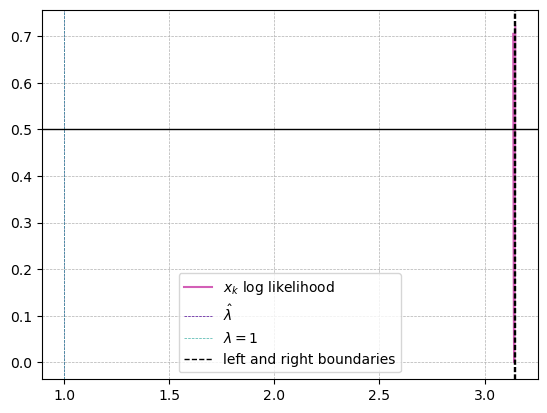

In [394]:
# We can visualize the boundaries and 0.5 threshold

plt.plot(lambdas, x_k_ll, color = '#d35fb7', label = '$x_k$ log likelihood');
plt.axvline(x = lambda_est, color = '#4b0092', label = '$\\hat{\\lambda}$', linewidth = 0.5, linestyle = "--");
plt.axvline(x = 1, color = '#40b0a6', label = '$\\lambda = 1$', linewidth = 0.5, linestyle = "--");
plt.axvline(x = left_boundary, color = '#000000', linewidth = 1, linestyle = "--");
plt.axvline(x = right_boundary, color = '#000000', label = 'left and right boundaries', linewidth = 1, linestyle = "--");
plt.axhline(y = 0.5, color = '#000000', linewidth = 1, linestyle = "-");
plt.grid(linestyle = '--', linewidth = 0.5);
plt.legend();

### _Question 5_

In [265]:
# Produce an alternative sample of N random values according to the logistic density with the 
# SciPy generator

x_log = sp.stats.logistic.rvs(size = 10**6)

# Print the first five elements of the sample

print(x_log[0:5])

[ 3.07440783  2.65548869 -6.11809136 -1.28848957 -1.75383921]


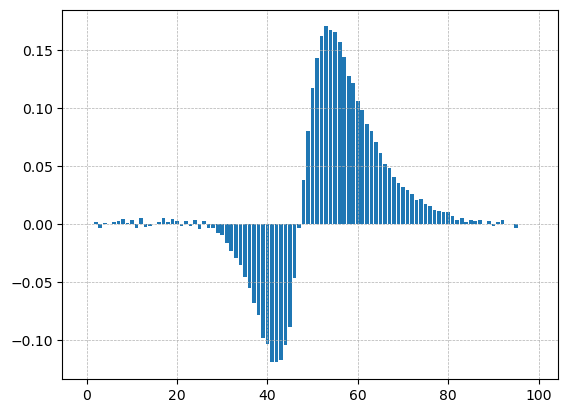

In [396]:
# Plot the residuals histogram to compare the logistic density random sample with the initial random sample

# Set number of bins
bins = 100

# Get values for each bin in the two random samples
hist_x_k, _ = np.histogram(x_k, bins = bins, density = True)
hist_x_log, _ = np.histogram(x_log, bins = bins, density = True)

# Calculate residuals, and approximate the uncertainty on the bin content with sqrt(n)
# We add a small constant value to avoid dividing by zero

resid = (hist_x_k - hist_x_log) / np.sqrt(hist_x_k + 1e-6)

# Plot the residuals histogram

plt.bar(x = range(bins), height = resid);
plt.grid(linestyle = '--', linewidth = 0.5);

The residuals are close to zero, which indicates that the two distributions align well.

### _Question 6_

In [273]:
# Use the x_k sample to build a new sample, z_k, where the random variable z is the standardized x value
# scaled by the factor 1 / sqrt(3)

z_k = (x_k - np.mean(x_k)) / (np.sqrt(3 * np.var(x_k)))
print(len(z_k))
print(z_k[0:5])

1000000
[ 0.26465916 -0.29154283 -0.39099355  0.0655593   0.30013644]


The variance of the rescaled variable z is expected by be close to 1/3. Is that the case ?

In [281]:
print(np.var(z_k))

0.3333333333333336


We repeat questions 1.3 and 1.4 with this logistic distribution

In [286]:
fitres_z_k = sp.optimize.minimize(neg_ll, x0 = [3], args = (z_k), method = 'Nelder-Mead')

# Extract the estimator value for lambda from the fitres object

lambda_est_z_k = fitres_z_k.x[0]

print(f'The lambda estimator that minimizes the defined maximum likelihood function has a value of {lambda_est_z_k:.5f}')

The lambda estimator that minimizes the defined maximum likelihood function has a value of 3.14150


In [292]:
# We define the parameters needed to evaluate the uncertainty using the graphical method (delta ln log likelihood = +/- 1/2 method)

margin = 0.005  # margin on each side of the lambda_est value
ls_size = 100  # size of the linear space which will be created
threshold = 0.5  # detection threshold

# Step 1 - create the linear space for theoretical lambda values

lambdas = np.linspace(start = lambda_est_z_k - margin, stop = lambda_est_z_k + margin, num = ls_size)

# Step 2 - calculate the neg log likelihood values for each of the values in {z_k},
# using the range of theoretical lambda values created in step 1

z_k_ll = [neg_ll(lambda_val = l, x = z_k) - fitres_z_k.fun for l in lambdas]

# Step 3 - create a Pandas dataframe containing the theoretical lambda values and associated
# z_k_ll values (we do this to facilitate the the uncertainty evaluation by manipulating a dataframe

df = pd.DataFrame({'lb': lambdas,
                  'z_k_ll': z_k_ll})

df.head()

# Step 3 - extract the minimal value of z_k_ll

z_k_ll_min = min(z_k_ll)
print(f'z_k_ll_min = {z_k_ll_min:.5f}')

# Step 4 - calculate the absolute value of the difference between z_k_ll and z_k_ll_min, increased by 0.5,
# and add this value in a new column

df = df.assign(diff_abs = abs(z_k_ll - (z_k_ll_min + 0.5)))

df.head()

# Step 5 - split the dataframe in two sub-tables, containing values to each side of the lambda estimator.
# Sort each table by increasing order of diff_abs values, and extract lambda value of the first row for each table.
# The lambda value extracted from the table to the 'left' of the lambda estimator corresponds to the left boundary,
# and the lambda value extracted from the table to the 'right' of the lambda estimator corresponds to the right boundary.

left_boundary = df[df.lb < lambda_est_z_k].sort_values('diff_abs').iloc[0]['lb']
right_boundary = df[df.lb > lambda_est_z_k].sort_values('diff_abs').iloc[0]['lb']

print(f'The left boundary is equal to {left_boundary:.5f}')
print(f'The right boundary is equal to {right_boundary:.5f}')

# Step 6 - calculate the 'sigma lambda hat' uncertainty

sigma_lambda_hat = (right_boundary - left_boundary) / 2

print(f'The lambda uncertainty is equal to {lambda_est_z_k:.5f} +/- {sigma_lambda_hat:.5f}')

z_k_ll_min = 0.00011
The left boundary is equal to 3.13893
The right boundary is equal to 3.14418
The lambda uncertainty is equal to 3.14150 +/- 0.00263


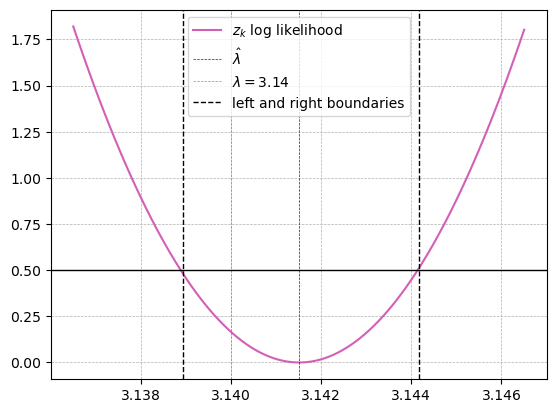

In [398]:
# We can visualize the boundaries and 0.5 threshold

plt.plot(lambdas, z_k_ll, color = '#d35fb7', label = '$z_k$ log likelihood');
plt.axvline(x = lambda_est_z_k, color = '#4b0092', label = '$\\hat{\\lambda}$', linewidth = 0.5, linestyle = "--");
plt.axvline(x = 3.14, color = '#40b0a6', label = '$\\lambda = 3.14$', linewidth = 0.5, linestyle = "--");
plt.axvline(x = left_boundary, color = '#000000', linewidth = 1, linestyle = "--");
plt.axvline(x = right_boundary, color = '#000000', label = 'left and right boundaries', linewidth = 1, linestyle = "--");
plt.axhline(y = 0.5, color = '#000000', linewidth = 1, linestyle = "-");
plt.grid(linestyle = '--', linewidth = 0.5);
plt.legend();

## <u>Part 2 - The accept-reject sampling method</u>

### _Question 1_

In [314]:
# We start by creating a linear space of x values

x = np.linspace(-5, 5, 1000)

In [316]:
# We then create a logistic and a normal distribution
# For the logistic distribution, we use an alpha minimal scaling factor to ensure the logistic distribution
# wraps the normal one for all x values
# By default, the mean ('loc') and sd ('scale') are assigned values 0 and 1

alpha_scale = 4 / np.sqrt(2 * np.pi)

pdf_logistic = sp.stats.logistic.pdf(x) * alpha_scale
pdf_normal = sp.stats.norm.pdf(x)

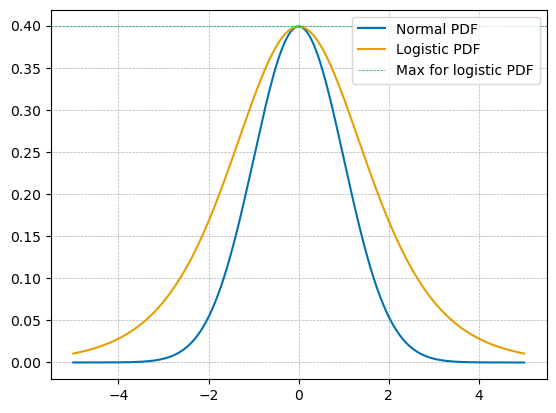

In [400]:
plt.plot(x, pdf_normal, color = '#0072b2', label = 'Normal PDF');
plt.plot(x, pdf_logistic, color = '#e69f00', label = 'Logistic PDF');
plt.axhline(y = (1 / np.sqrt(2 * np.pi)), color = '#009e73', linestyle = '--', linewidth = 0.5,
           label = 'Max for logistic PDF');
plt.grid(linestyle = '--', linewidth = 0.5);
plt.legend();

### _Question 2_

In [402]:
# For each event in the random logistic sample x_log :
# evaluate the ratio r(x_log) = N(x_log) / alpha
# generate a random probability p uniformaly distributed in [0,1]
# if r(x_log) >= p save x_log in the subsample of accepted values

# We start by defining a accept/reject function

def accept_reject(x) :

    accepted_values = []

    alpha_scale = 4 / np.sqrt(2 * np.pi)

    for i in x:

        r = sp.stats.norm.pdf(i) / (sp.stats.logistic.pdf(i) * alpha_scale)

        p = np.random.uniform(low = 0, high = 1)

        if r >= p:

            accepted_values.append(i)

    m = len(accepted_values)
    n = len(x)
    m_n = m / n

    print(f'Total number of values : N = {n}')
    print(f'Number of accepted values : M = {m}')
    print(f'Acceptance rate : M / N = {m_n:.4f}')

    return(accepted_values)

In [404]:
# We generate a sample of logistic distribution
values_log = sp.stats.logistic.rvs(size = 10**5)

In [406]:
# We apply the accept / reject function to that sample, and save accepted values in xm_a
xm_a = accept_reject(x = values_log)

Total number of values : N = 100000
Number of accepted values : M = 62721
Acceptance rate : M / N = 0.6272


### _Question 3_

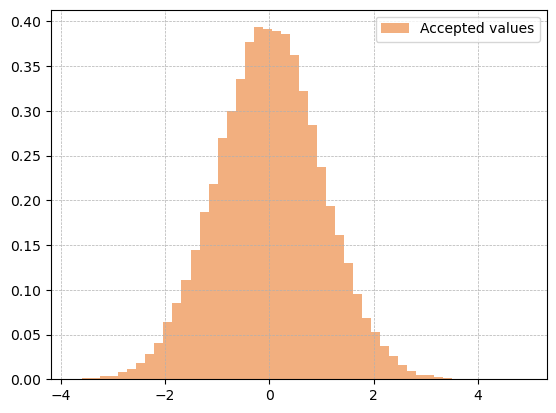

In [408]:
# Draw the density histogram for the subsample of accepted values xm_a
plt.hist(xm_a, bins = 50, color = '#e66100', alpha = 0.5, density = True, label = 'Accepted values');
plt.legend();
plt.grid(linestyle = '--', linewidth = 0.5);

In [428]:
# Extract the mean (mu_hat) and standard deviation (sigma_hat) from the subsample using sp.stats.norm.fit

mu_hat, sigma_hat = sp.stats.norm.fit(xm_a)

print(f'The mu estimator for the subsample of accepted values is {mu_hat:.4f}')
print(f'The sigma estimator for the subsample of accepted values is {sigma_hat:.4f}')

The mu estimator for the subsample of accepted values is -0.0015
The sigma estimator for the subsample of accepted values is 1.0003


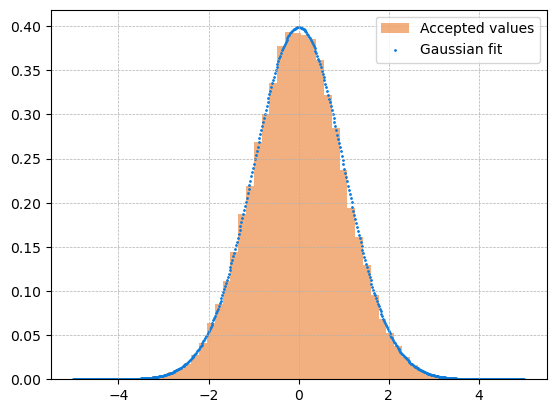

In [452]:
# Verify the density histogram exhibits the normal profile by performing a fit of the gaussian PDF to the subsample

x_fit = np.linspace(start = -5, stop = 5, num = 500)
y_fit = sp.stats.norm.pdf(x = x_fit, loc = mu_hat, scale = sigma_hat)

#xm_a_fit = sp.stats.norm.pdf(x = xm_a, loc = mu_hat, scale = sigma_hat)

plt.hist(xm_a, bins = 50, color = '#e66100', alpha = 0.5, density = True, label = 'Accepted values');
plt.scatter(x = x_fit, y = y_fit, color = '#0c7bdc', label = 'Gaussian fit', s = 1);
plt.legend();
plt.grid(linestyle = '--', linewidth = 0.5);

### _Question 4_

In [454]:
# Step 4: Use a uniform reference distribution over [-10, 10] for logistic sampling
uniform_a, uniform_b = -10, 10  # Define the range
uniform_pdf = 1 / (uniform_b - uniform_a)  # Uniform PDF in the range
beta0_uniform = 1 / uniform_pdf  # Scaling factor to wrap logistic distribution

accepted_samples_uniform = []

In [ ]:
# Generate logistic samples and perform accept-reject with uniform reference
for x in x_log:
    if uniform_a <= x <= uniform_b:
        r_x_uniform = sp.stats.logistic.pdf(x) / beta0_uniform
        p = np.random.uniform(0, 1)
        if r_x_uniform >= p:
            accepted_samples_uniform.append(x)

In [ ]:
# Calculate acceptance rate
M = len(accepted_samples_uniform)
N = len(x_log)
acceptance_rate = M / N
print(f"Acceptance Rate (M/N): {acceptance_rate:.4f}")

In [ ]:
# Fit a Gaussian to the accepted sample and plot
mu_hat, sigma_hat = sp.stats.norm.fit(accepted_samples_uniform)
fitted_pdf_vals = sp.stats.norm.pdf(x, mu_hat, sigma_hat)
plt.plot(x, fitted_pdf_vals)

plt.xlabel("x")
plt.ylabel("Density")
plt.title("Histogram of Accepted Samples with Fitted Gaussian PDF")